In [15]:
import pandas as pd
import numpy as np
import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
import matplotlib.pyplot as plt

In [16]:
# 2. Cargar y preprocesar los datos
X_train = pd.read_csv("../Datos/Train_X.csv")
y_train = pd.read_csv("../Datos/Train_Y.csv").values.ravel()

X_val = pd.read_csv("../Datos/Validation_1.csv")
y_val = pd.read_csv("../Datos/Validation_2.csv").values.ravel()

X_test = pd.read_csv("../Datos/Test_1.csv")
y_test = pd.read_csv("../Datos/Test_2.csv").values.ravel()

# 1. Manejo de valores faltantes
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Para columnas numéricas, rellenar con la mediana
for col in numeric_cols:
    median_value = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_value)
    X_val[col] = X_val[col].fillna(median_value)
    X_test[col] = X_test[col].fillna(median_value)

# Para columnas categóricas, rellenar con el modo
for col in categorical_cols:
    mode_value = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_value)
    X_val[col] = X_val[col].fillna(mode_value)
    X_test[col] = X_test[col].fillna(mode_value)

# 2. Preprocesamiento de variables categóricas
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in categorical_cols:
    if X_train[col].nunique() <= 5:  
        unique_vals = pd.concat([X_train[col], X_val[col], X_test[col]]).unique()
        le = LabelEncoder()
        le.fit(unique_vals)
        
        X_train[col] = le.transform(X_train[col])
        X_val[col] = le.transform(X_val[col])
        X_test[col] = le.transform(X_test[col])
    else: 
        train_dummies = pd.get_dummies(X_train[col], prefix=col)
        val_dummies = pd.get_dummies(X_val[col], prefix=col)
        test_dummies = pd.get_dummies(X_test[col], prefix=col)
        
        all_cols = train_dummies.columns.union(val_dummies.columns).union(test_dummies.columns)
        
        for dummy_col in all_cols:
            if dummy_col not in train_dummies.columns:
                train_dummies[dummy_col] = 0
            if dummy_col not in val_dummies.columns:
                val_dummies[dummy_col] = 0
            if dummy_col not in test_dummies.columns:
                test_dummies[dummy_col] = 0
        
        train_dummies = train_dummies.reindex(columns=all_cols)
        val_dummies = val_dummies.reindex(columns=all_cols)
        test_dummies = test_dummies.reindex(columns=all_cols)
        
        X_train = pd.concat([X_train.drop(col, axis=1), train_dummies], axis=1)
        X_val = pd.concat([X_val.drop(col, axis=1), val_dummies], axis=1)
        X_test = pd.concat([X_test.drop(col, axis=1), test_dummies], axis=1)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")
print("\nColumnas después del preprocesamiento:")
print(X_train.columns.tolist())

Train shape: (600, 8), Validation shape: (200, 8), Test shape: (200, 8)

Columnas después del preprocesamiento:
['Order_ID', 'Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs']


In [17]:
# 3. Normalizar los datos (importante para KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Datos normalizados correctamente")

Datos normalizados correctamente


In [18]:
# 3. Definir combinaciones de hiperparámetros
params = {
    "n_neighbors": [3, 5, 7, 10, 15],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # 1: Manhattan, 2: Euclidean
}

print("Hiperparámetros:")
for k, v in params.items():
    print(f"  {k}: {v}")

Hiperparámetros:
  n_neighbors: [3, 5, 7, 10, 15]
  weights: ['uniform', 'distance']
  p: [1, 2]


In [19]:
# 4. Entrenar y evaluar todas las combinaciones
resultados = []

for n_neighbors, weights, p in product(
    params["n_neighbors"], params["weights"], params["p"]
):
    start = time.time()
    
    model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p,
        n_jobs=-1  # usar todos los núcleos disponibles
    )
    model.fit(X_train_scaled, y_train)
    
    end = time.time()
    tiempo_total = end - start
    
    # Predicciones
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    
    # Métricas
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_val = mean_squared_error(y_val, y_val_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_val = np.sqrt(mse_val)
    r2_train = r2_score(y_train, y_train_pred)
    r2_val = r2_score(y_val, y_val_pred)
    
    resultados.append({
        "n_neighbors": n_neighbors,
        "weights": weights,
        "distance_metric": "Manhattan" if p == 1 else "Euclidean",
        "RMSE_Train": rmse_train,
        "RMSE_Val": rmse_val,
        "R2_Train": r2_train,
        "R2_Val": r2_val,
        "Tiempo (s)": round(tiempo_total, 3)
    })
    
    print(f"Modelo terminado: n_neighbors={n_neighbors}, weights={weights}, metric={'Manhattan' if p == 1 else 'Euclidean'}, tiempo={tiempo_total:.2f}s")

Modelo terminado: n_neighbors=3, weights=uniform, metric=Manhattan, tiempo=0.00s
Modelo terminado: n_neighbors=3, weights=uniform, metric=Euclidean, tiempo=0.00s
Modelo terminado: n_neighbors=3, weights=distance, metric=Manhattan, tiempo=0.00s
Modelo terminado: n_neighbors=3, weights=distance, metric=Euclidean, tiempo=0.00s
Modelo terminado: n_neighbors=5, weights=uniform, metric=Manhattan, tiempo=0.00s
Modelo terminado: n_neighbors=5, weights=uniform, metric=Euclidean, tiempo=0.00s
Modelo terminado: n_neighbors=5, weights=uniform, metric=Euclidean, tiempo=0.00s
Modelo terminado: n_neighbors=5, weights=distance, metric=Manhattan, tiempo=0.00s
Modelo terminado: n_neighbors=5, weights=distance, metric=Manhattan, tiempo=0.00s
Modelo terminado: n_neighbors=5, weights=distance, metric=Euclidean, tiempo=0.00s
Modelo terminado: n_neighbors=7, weights=uniform, metric=Manhattan, tiempo=0.00s
Modelo terminado: n_neighbors=7, weights=uniform, metric=Euclidean, tiempo=0.00s
Modelo terminado: n_nei

In [20]:
# 5. Crear tabla comparativa de resultados
df_resultados = pd.DataFrame(resultados)
df_resultados_sorted = df_resultados.sort_values(by="RMSE_Val")
display(df_resultados_sorted.head(10))  # mostrar los 10 mejores modelos

print("\nMejor modelo según RMSE en validación:")
mejor = df_resultados_sorted.iloc[0]
print(mejor)

,n_neighbors,weights,distance_metric,RMSE_Train,RMSE_Val,R2_Train,R2_Val,Tiempo (s)
19,15,distance,Euclidean,0.000000,11.906219,1.000000,0.688367,0.001
17,15,uniform,Euclidean,12.768591,11.997401,0.673630,0.683575,0.002
18,15,distance,Manhattan,0.000000,12.261255,1.000000,0.669504,0.001
15,10,distance,Euclidean,0.000000,12.273811,1.000000,0.668827,0.001
14,10,distance,Manhattan,0.000000,12.302668,1.000000,0.667268,0.001
13,10,uniform,Euclidean,12.452181,12.374355,0.689605,0.663379,0.001
6,5,distance,Manhattan,0.000000,12.399798,1.000000,0.661993,0.001
16,15,uniform,Manhattan,12.912616,12.488596,0.666226,0.657135,0.001
12,10,uniform,Manhattan,12.423749,12.525807,0.691021,0.655089,0.001
10,7,distance,Manhattan,0.000000,12.556823,1.000000,0.653379,0.001



Mejor modelo según RMSE en validación:
n_neighbors               15
weights             distance
distance_metric    Euclidean
RMSE_Train               0.0
RMSE_Val           11.906219
R2_Train                 1.0
R2_Val              0.688367
Tiempo (s)             0.001
Name: 19, dtype: object



--- Rendimiento final ---
RMSE (Test): 13.8720
R² (Test): 0.5916


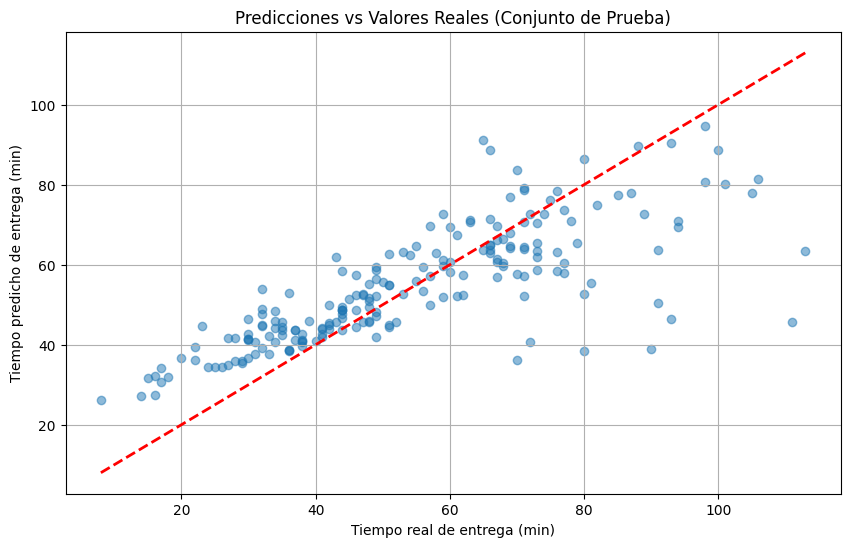

In [21]:
# 6. Evaluación final del mejor modelo
mejor_modelo = KNeighborsRegressor(
    n_neighbors=int(mejor["n_neighbors"]),
    weights=mejor["weights"],
    p=1 if mejor["distance_metric"] == "Manhattan" else 2,
    n_jobs=-1
)
mejor_modelo.fit(X_train_scaled, y_train)

y_test_pred = mejor_modelo.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\n--- Rendimiento final ---")
print(f"RMSE (Test): {rmse_test:.4f}")
print(f"R² (Test): {r2_test:.4f}")

# Visualización de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo real de entrega (min)')
plt.ylabel('Tiempo predicho de entrega (min)')
plt.title('Predicciones vs Valores Reales (Conjunto de Prueba)')
plt.grid(True)
plt.show()

In [22]:
# 7. Predicción con un dato inventado
# Crear un DataFrame con todas las columnas necesarias
columnas_modelo = X_train.columns
nuevo = pd.DataFrame(0, index=[0], columns=columnas_modelo)

# Establecer los valores básicos
nuevo['Distance_km'] = 5.0
nuevo['Preparation_Time_min'] = 20
nuevo['Courier_Experience_yrs'] = 2

# Para las columnas categóricas codificadas, usar los valores más comunes
# Las columnas dummy ya están en 0 por defecto

# Escalar el nuevo dato usando el mismo scaler
nuevo_scaled = scaler.transform(nuevo)
pred_nuevo = mejor_modelo.predict(nuevo_scaled)

print("\nPredicción para un nuevo pedido:")
print("Características del pedido:")
print(f"- Distancia: {nuevo['Distance_km'].iloc[0]:.1f} km")
print(f"- Tiempo de preparación: {nuevo['Preparation_Time_min'].iloc[0]} min")
print(f"- Experiencia del repartidor: {nuevo['Courier_Experience_yrs'].iloc[0]} años")
print(f"\nTiempo estimado de entrega: {pred_nuevo[0]:.2f} minutos")


Predicción para un nuevo pedido:
Características del pedido:
- Distancia: 5.0 km
- Tiempo de preparación: 20 min
- Experiencia del repartidor: 2 años

Tiempo estimado de entrega: 50.85 minutos
